## Preprocessing steps

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re

import pandas as pd
import re

# Load the CSV file
data = pd.read_csv(r"C:\Users\Karthik Shetty\Desktop\Db System for analytics\project\combined_result.csv", low_memory=False)

# Check for missing values in critical columns and decide how to handle them
data['abstract'] = data['abstract'].fillna('')  # Replace NaN with empty strings
data['pub_date'] = data['pub_date'].ffill()  # Forward fill missing dates if applicable

# Function to clean text data
def clean_text(text):
    # Convert to lowercase to maintain consistency
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning function to the 'abstract' column
data['abstract'] = data['abstract'].apply(clean_text)

# Convert 'pub_date' to datetime and extract year and month
data['pub_date'] = pd.to_datetime(data['pub_date'], errors='coerce')  # Coerce errors will turn problematic data into NaT
data['year'] = data['pub_date'].dt.year
data['month'] = data['pub_date'].dt.month

# Analyzing text length of abstracts after cleaning
data['abstract_length'] = data['abstract'].apply(len)


In [19]:
# pip install --upgrade pandas seaborn


Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils, models
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.dates as mdates
from datetime import datetime

# Load the data
data = pd.read_csv(r"C:\Users\Karthik Shetty\Desktop\Db System for analytics\project\combined_result.csv")

# Convert 'pub_date' to datetime and extract year and month
data['pub_date'] = pd.to_datetime(data['pub_date'])
data['year'] = data['pub_date'].dt.year
data['month'] = data['pub_date'].dt.month

# Ensure all text data is string type; replace NaNs with empty strings
data['abstract'] = data['abstract'].fillna('').astype(str)

# Analyze text length of abstracts
data['abstract_length'] = data['abstract'].apply(len)

# Sentiment analysis using TextBlob
data['sentiment'] = data['abstract'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Convert the text data into a term-document matrix
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_cv = cv.fit_transform(data['abstract'])
tdm = data_cv.transpose()

# Convert the term-document matrix into a gensim-friendly format
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# LDA model
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10)
lda.print_topics()


[(0,
  '0.027*"department" + 0.023*"federal" + 0.016*"case" + 0.015*"justice" + 0.013*"trial" + 0.012*"law" + 0.011*"said" + 0.010*"judge" + 0.010*"criminal" + 0.010*"documents"'),
 (1,
  '0.041*"president" + 0.039*"trump" + 0.029*"house" + 0.024*"said" + 0.021*"white" + 0.015*"mr" + 0.012*"committee" + 0.011*"general" + 0.009*"donald" + 0.008*"attorney"'),
 (2,
  '0.023*"election" + 0.018*"republican" + 0.017*"party" + 0.016*"democrats" + 0.015*"republicans" + 0.012*"state" + 0.011*"voters" + 0.010*"democratic" + 0.010*"senate" + 0.008*"2020"'),
 (3,
  '0.032*"president" + 0.020*"campaign" + 0.017*"republican" + 0.016*"senator" + 0.015*"mr" + 0.014*"presidential" + 0.013*"obama" + 0.011*"democratic" + 0.010*"clinton" + 0.009*"new"'),
 (4,
  '0.025*"president" + 0.018*"house" + 0.014*"capitol" + 0.013*"republicans" + 0.013*"democrats" + 0.011*"congress" + 0.011*"lawmakers" + 0.011*"health" + 0.010*"senate" + 0.009*"said"'),
 (5,
  '0.210*"biden" + 0.053*"new" + 0.037*"york" + 0.034*"ti

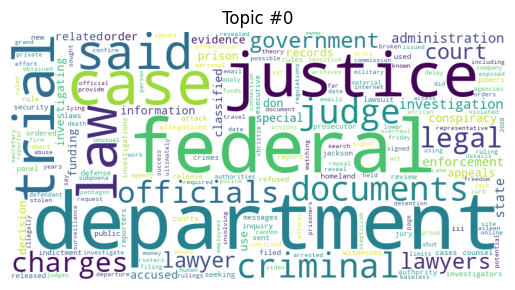

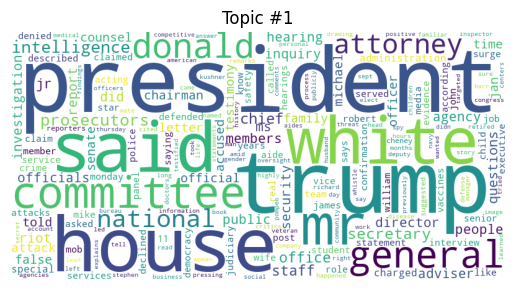

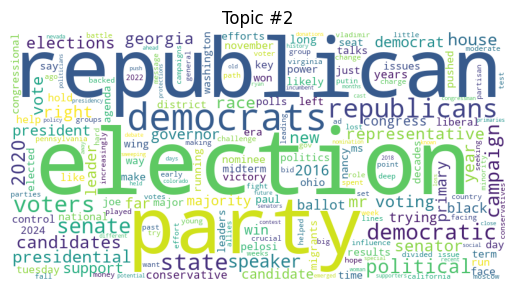

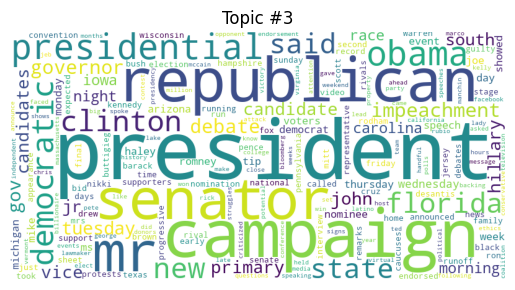

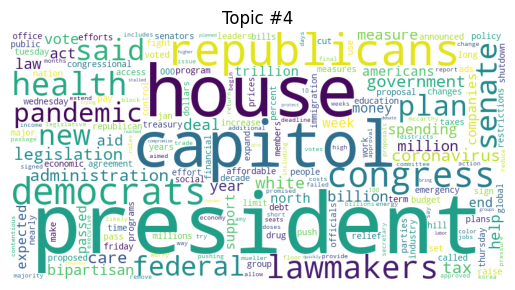

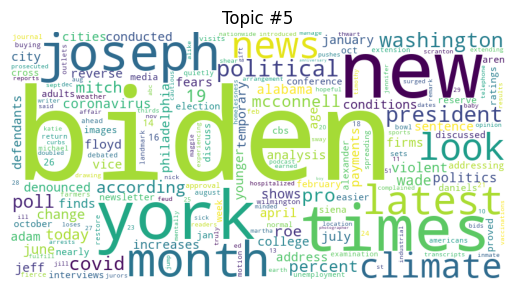

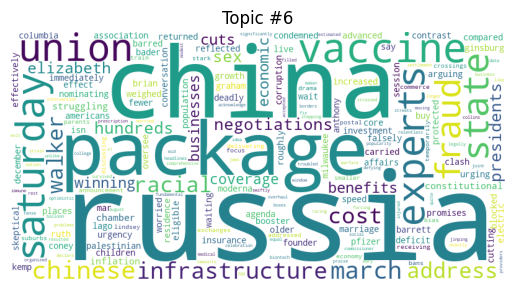

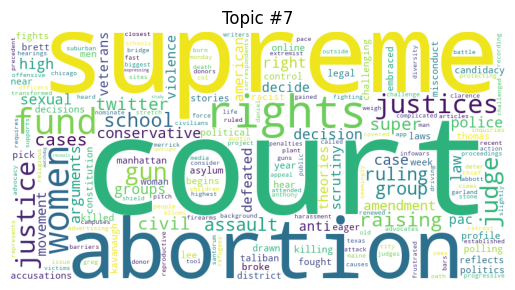

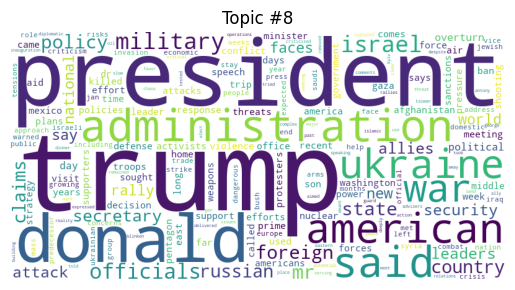

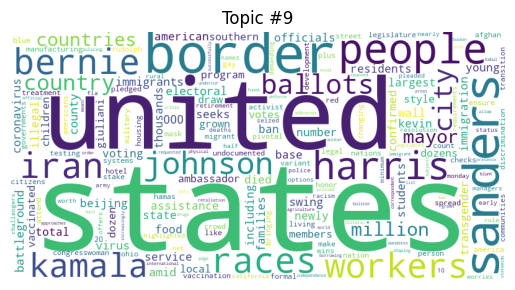

In [7]:
from wordcloud import WordCloud

# Generate Word Cloud for each topic
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', width=800, height=400).fit_words(dict(lda.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()


## SENTIMENT ANALYSIS

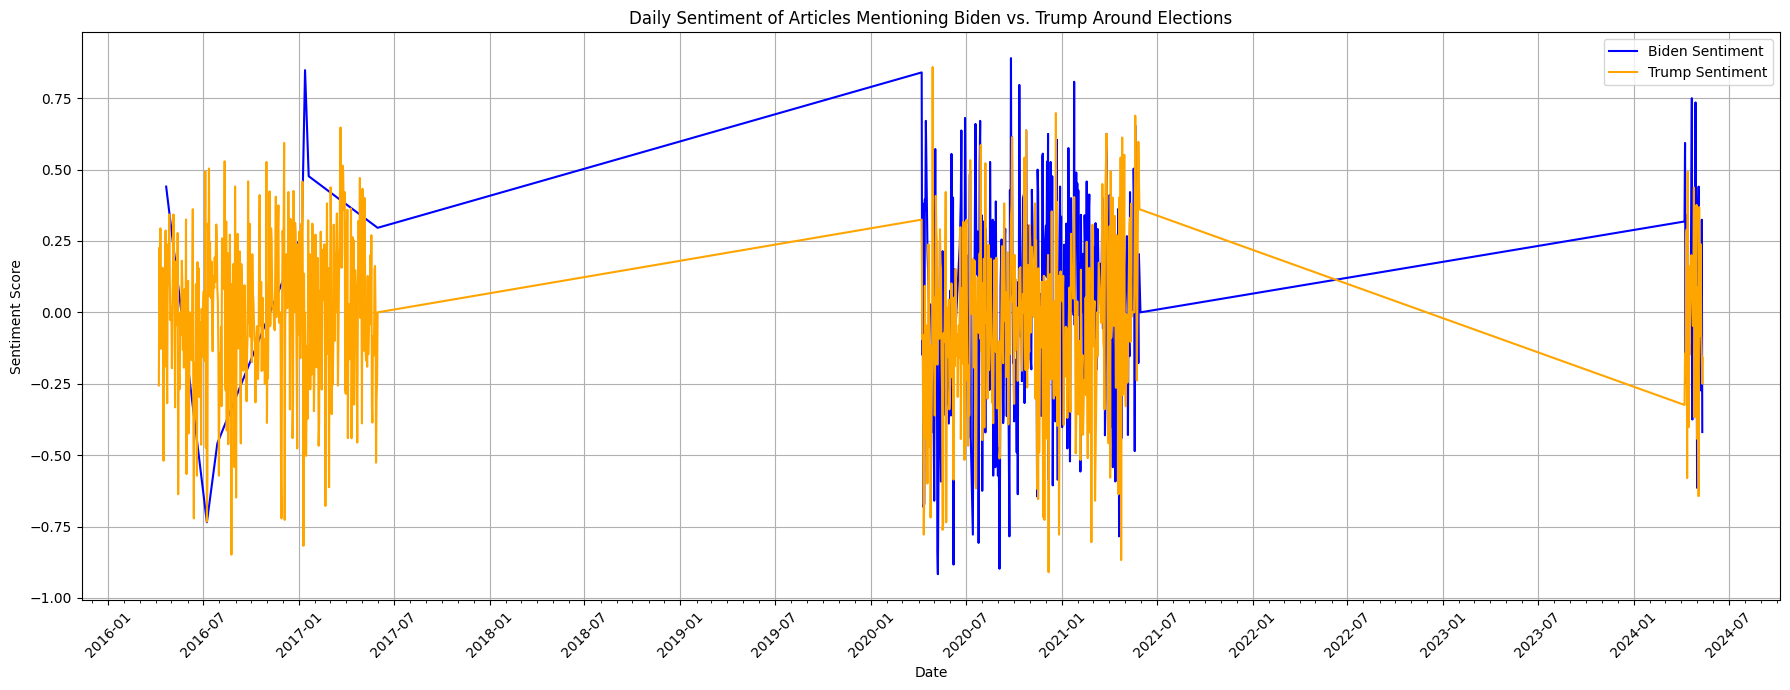

In [15]:
# Load data and ensure datetime conversion
data['pub_date'] = pd.to_datetime(data['pub_date'], errors='coerce')

# Normalize all datetimes by removing any timezone information
data['pub_date'] = data['pub_date'].dt.tz_localize(None)

# Sentiment analysis setup
analyzer = SentimentIntensityAnalyzer()
data['abstract'] = data['abstract'].fillna('').astype(str)  # Handling NaNs
data['sentiment'] = data['abstract'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Define election years, including the current year
current_year = datetime.now().year
election_years = [2016, 2020, 2024]
if current_year > 2024:
    election_years.append(current_year)

days_range =210 #|days before and after the election date (if before election, adjust accordingly)

frames_biden, frames_trump = [], []
for year in election_years:
    election_date = pd.Timestamp(year=year, month=11, day=3)  # US elections are in November
    if datetime.now() < election_date:
        end_date = datetime.now()
    else:
        end_date = election_date + pd.Timedelta(days=days_range)
    start_date = election_date - pd.Timedelta(days=days_range)

    # Filter data for Biden and Trump around the election dates
    filtered_biden = data[(data['abstract'].str.contains('Biden', case=False)) & 
                          (data['pub_date'] >= start_date) & (data['pub_date'] <= end_date)]
    filtered_trump = data[(data['abstract'].str.contains('Trump', case=False)) & 
                          (data['pub_date'] >= start_date) & (data['pub_date'] <= end_date)]

    frames_biden.append(filtered_biden)
    frames_trump.append(filtered_trump)

# Concatenate all the frames
final_biden = pd.concat(frames_biden)
final_trump = pd.concat(frames_trump)

# Calculate daily mean sentiment
biden_daily = final_biden.groupby(final_biden['pub_date'].dt.date)['sentiment'].mean()
trump_daily = final_trump.groupby(final_trump['pub_date'].dt.date)['sentiment'].mean()

# Assuming the plot size and other parameters are set correctly
fig, ax = plt.subplots(figsize=(18, 7))  # Large figure size for clarity

# Plotting sentiment data
ax.plot(biden_daily.index, biden_daily, label='Biden Sentiment', color='blue')
ax.plot(trump_daily.index, trump_daily, label='Trump Sentiment', color='orange')

# Set major ticks to every six months
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))  # January and July
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set minor ticks to every month
ax.xaxis.set_minor_locator(mdates.MonthLocator())  # Every month

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add grid, labels, title, and legend
plt.grid(True)
plt.title('Daily Sentiment of Articles Mentioning Biden vs. Trump Around Elections')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()

# Layout adjustment to prevent clipping of tick-labels
plt.tight_layout()
plt.show()
